# GSP API Query Example code

By: Simón Torres - 25-02-2022

The Goodman Spectroscopic API documentation can be found here:

http://soarvm2.ctio.noao.edu/gsp/api/docs/

For documentation on how to make filtering to apis created with Django Rest Framework visit here
https://www.django-rest-framework.org/api-guide/filtering/


## Requirements

### Get the API Token

Login into GSP web application at http://soarvm2.ctio.noao.edu/gsp/web
Then click on your name at the left of the screen (1) and copy your API Token (2)

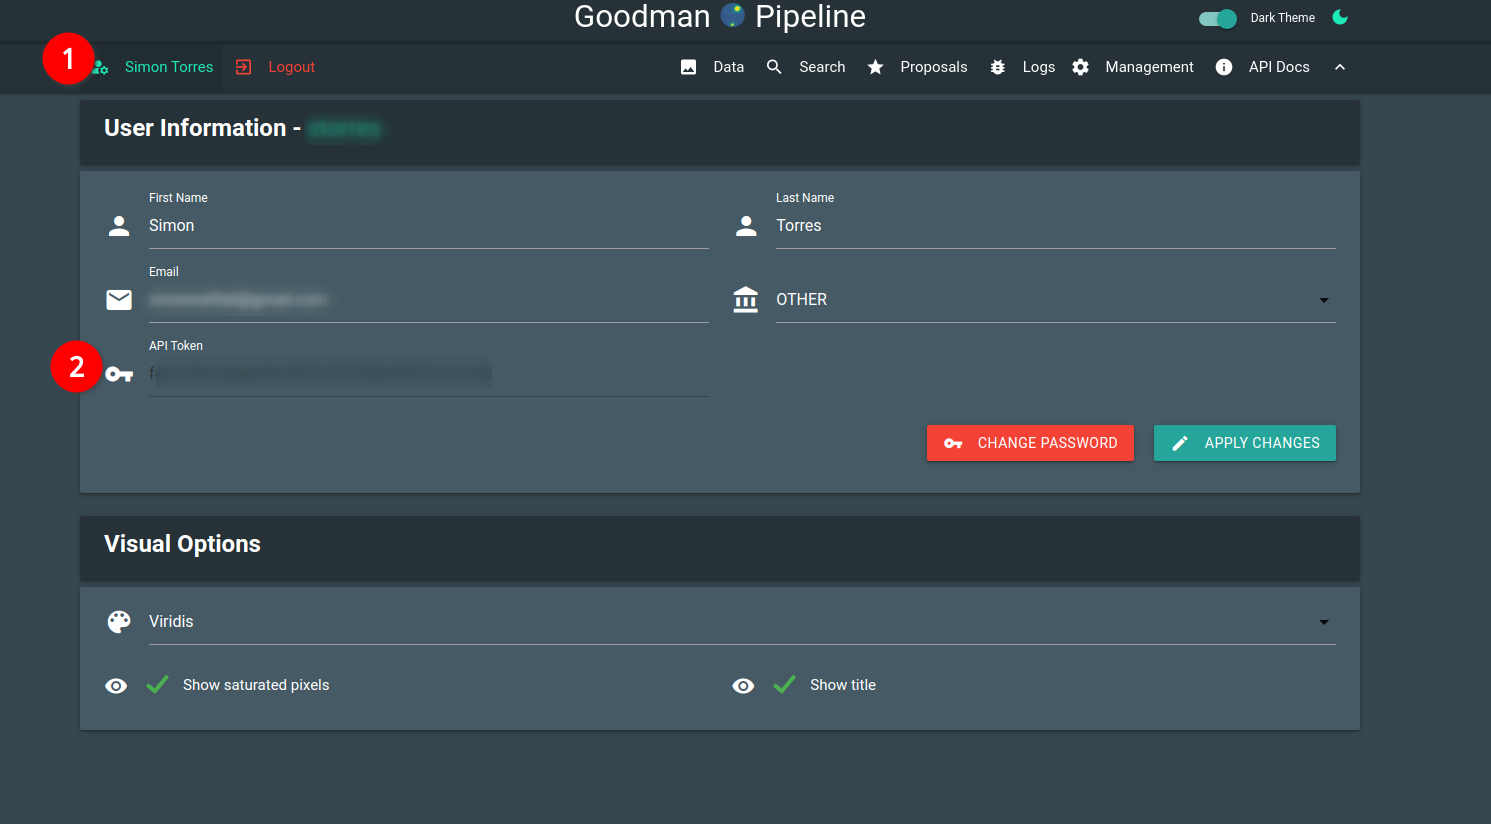

- VPN Connection
- User account (API Token)

### Imports

In [3]:
import json
import requests
from configparser import ConfigParser

### Get the token

You can just copy and paste it as a regular variable

In [4]:
parser = ConfigParser()
_ = parser.read('secrets.cfg')

API_KEY = parser.get('gsp_api', 'api_token')



### Search

Using the `?search=xxx` querystrings will search for `xxx` in the following fields.

- `file_name`
- `obstype`
- `object`
- `filter`
- `filter_2`
- `grating`
- `slit`
- `obsra`
- `obsdec`
- `roi`
- `wavmode`
- `proposal_id`
- `block_id`
- `date`

### Single image fields

The following json data contains all the fields that will be returned by the API regarding a single file.

```json
{
    "id": 1288,
    "download_url": "/downloads/0b98493568eb4b29429132bbb913d291/20210907/RAW/0308_J0220-7022_06-09-2021.fits",
    "created": "2021-09-08T04:33:44.466543Z",
    "last_modified": "2021-11-17T20:40:19.786213Z",
    "original_file": "0308_J0220-7022_06-09-2021.fits",
    "original_file_id": 1288,
    "parent_file": "0308_J0220-7022_06-09-2021.fits",
    "parent_file_id": 1288,
    "file_name": "0308_J0220-7022_06-09-2021.fits",
    "obstype": "SPECTRUM",
    "object": "J0220-7022",
    "filter": "NO_FILTER",
    "filter_2": "NO_FILTER",
    "grating": "400_SYZY",
    "slit": "1.0_LONG_SLIT",
    "cam_targ": "11.6",
    "grt_targ": "5.8",
    "airmass": "1.31",
    "obsra": "02:20:09.010",
    "obsdec": "-70:22:30.439",
    "gain": "1.48",
    "rdnoise": "3.89",
    "roi": "Spectroscopic 2x2",
    "wavmode": "400_M1",
    "exptime": "1800.0",
    "camera": "Red",
    "binning": "2 2",
    "lamp_hg_ar": false,
    "lamp_ne": false,
    "lamp_ar": false,
    "lamp_fe_he_ar": false,
    "lamp_cu_he_ar": false,
    "lamp_quartz": false,
    "lamp_quartz_percent": "0.0",
    "lamp_bulb": false,
    "lamp_dome": false,
    "lamp_dome_percent": "0.0",
    "seeing": "-1.00",
    "proposal_id": "SOAR2021B-001",
    "observation_id": 6520948,
    "configuration_id": 381840141,
    "block_id": 284101165,
    "image_id": 73825,
    "date": "2021-09-06",
    "date_time": "2021-09-06T07:50:11.467000Z",
    "data_type": "0",
    "normalized": false,
    "technique": "Spectroscopy",
    "is_usable": true,
    "saturation_value": 69257
}
```

### Compose your query

`data_type` allows you to filter ~obviously~ the type of data that you want to get, the choices are sumarized in the following table


| Value  | Name                  | Description                                  |
|--------|-----------------------|----------------------------------------------|
| 0      | Raw Data              | Image directly from the instrument           |
| 1      | Calibration           | Master Calibration File                      |
| 2      | Reduced               | Up to cosmic ray rejection                   |
| 3      | Extracted             | 1-D spectrum extracted files, no calibration |
| 4      | Wavelength Calibrated | Wavelength Calibrated 1D spectra             |
| 5      | Flux Calibrated       | Flux Calibrated Files                        |
|        | Plate Solved          | Astrometric Solution applied                 |


Neither 5 or "6" (plate solving) are fully implemented yet.


The query responses are "paginated", this is useful because it reduces the size of each response but to get all the data you would have to make the same request specifying the page. This is done in a previous/next manner, this means that each response will have a field `previous` or `next`.

```json
{
    "count": 487,
    "next": "http://ctioy9.ctio.noao.edu/gsp/api/files/?page=3&search=flat",
    "previous": "http://ctioy9.ctio.noao.edu/gsp/api/files/?search=flat",
    "results": [...]
}
```

**Make sure you remove the last `break` in the following code**

In [7]:
API_SERVER = 'http://soarvm2.ctio.noao.edu'

target_url = f"{API_SERVER}/gsp/api/files/?slit=1.0_LONG_SLIT&data_type=0&wavmode=400_M1"
# target_url = f"{API_SERVER}/gsp/api/files/?object=HD84937"
# target_url = f"{API_SERVER}/gsp/api/files/?saturation_value=69257"

while True:
    response = requests.get(
        url=target_url,
        headers={
            'Content-Type': 'application/json',
            'Authorization': f"Token {API_KEY}"
        })
    if response.status_code == 200:
        json_response = response.json()
        print(f"Found {json_response['count']} results")
        # print(json_response['previous'])
        # print(json.dumps(json_response, indent=4))
        for res in json_response['results']:
            print(f"{API_SERVER}{res['download_url']}")
        if json_response['next'] is not None:
            target_url = json_response['next']
        else:
            break
    else:
        print(response)
    # Remove this last break to efectively go through all the pages of the query
    break

Found 5463 results
http://soarvm2.ctio.noao.edu/downloads/f5823e7a51f6bf25796835b6619671db/20220223/RAW/0305_2022crr_24-02-2022_comp.fits
http://soarvm2.ctio.noao.edu/downloads/24c908e1f053c3dac99f5e160cea575e/20220223/RAW/0304_2022crr_24-02-2022.fits
http://soarvm2.ctio.noao.edu/downloads/23e461c77c8f98031bc70ca114bb3836/20220223/RAW/0294_2022ann_24-02-2022_comp.fits
http://soarvm2.ctio.noao.edu/downloads/43a6bc6af27b75fb0dbfec083dbace98/20220223/RAW/0293_2022ann_24-02-2022.fits
http://soarvm2.ctio.noao.edu/downloads/5b96d8f603259e8cf2bc5aea66998762/20220223/RAW/0290_J050746-670316_24-02-2022_comp.fits
http://soarvm2.ctio.noao.edu/downloads/f258c3506b7df42d95dec14d1464a2c2/20220223/RAW/0289_J050746-670316_24-02-2022.fits
http://soarvm2.ctio.noao.edu/downloads/5a34ec9b9cdf68e6a8b63dfe9d90e3d0/20220223/RAW/0288_J050410-661205_24-02-2022_comp.fits
http://soarvm2.ctio.noao.edu/downloads/d42e30ac2d737bffe51b03d37026e88e/20220223/RAW/0287_J050410-661205_24-02-2022.fits
http://soarvm2.ctio.n

http://soarvm2.ctio.noao.edu/downloads/13593c897d294279ac221aa803a4edc8/20220223/RAW/0161_GHTS_R_400m1_2x2_23-02-2022.fits